# Multiyear analysis
George Brencher, some code from Daniel Hogan

-----------------------------------------------------

This notebook has similar functionality to the '04analysis' notebook, but for multiple years. 

In [1]:
# import required packages
# depending on your environment, you may need to install some of these
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import dask
import geopandas as gpd
import rasterio as rio
import datetime as dt
import requests
import pandas as pd
import sys
import contextily as cx
import seaborn as sns

In [2]:
ds_list = []
for ds_path in glob.glob('./data/*.nc'):
    ds = xr.open_dataset(ds_path)
    ds = ds.drop_vars('band')
    ds = ds.drop('s1')
    ds = ds.transpose('time', 'y', 'x')
    if ds_list:
        ds = ds.rio.reproject_match(ds_list[0])
    ds_list.append(ds)
    
ds = xr.concat(ds_list, dim='time')

ds = ds.sortby('time')

# reproject dataset to utm zone
crs = ds.rio.estimate_utm_crs()
ds = ds.rio.reproject(crs)

# open aoi geojson as geopandas dataframe and reproject
aoi_fn = './east_river_basin_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# clip dataset to aoi
ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

# exclude orbit without full coverage
ds = ds.where(ds.relative_orbit!=129.0, drop=True)

In [6]:
ds.to_netcdf('./data/sd_2016-2022_east-river.nc')

In [3]:
# function to query SNOTEL api
def get_awdb_data(
    site_ids,
    server,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=dt.datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}/{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

In [4]:
# function to download data for SNOTEL sites within some buffer distance of the site. 
def grab_snotel(aoi_gdf,
                buffer=1000,
                elements=["TAVG","SNWD","WTEQ"]
):
    '''
    Takes a geodataframe containing an area of interest and returns SNOTEL data from 
    stations within some distance of that area of interest. Geodataframe assumed to 
    be projected in appropriate utm zone. 
    '''
    # get SNTL data using an API built by Beau Uriona
    AWDB_API_DOMAIN = "https://api.snowdata.info"

    # pull in metadata for all NRCS SNOTEL sites
    sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"
    sntl_gdf = gpd.read_file(sntl_meta_url).to_crs(aoi_gdf.crs)

    # find sites within some distance of aoi
    buf_gdf = aoi_gdf.copy(deep=True)
    buf_gdf['geometry'] = buf_gdf.buffer(buffer)
    sntl_gdf = gpd.overlay(sntl_gdf, buf_gdf, how='intersection')
    
    # raise error if no site are found
    if sntl_gdf.empty:
        raise Exception(f'No SNOTEL sites within {buffer}m of aoi. Try a larger buffer.') 
    
    # build dict with station names and ids
    site_ids = list(sntl_gdf.stationTriplet)
    
    # download snotel data
    sntl_dfs = get_awdb_data(site_ids, server=AWDB_API_DOMAIN)
    
    # Make the index a datetime
    for i,df in enumerate(sntl_dfs):
        df.index = pd.to_datetime(df.index)
        sntl_dfs[i] = df

    # create a dictionary for conversion to xarray
    sntl_df_dict = {}
    counter = 0
    for i, site in enumerate(site_ids):
        sntl_df_dict[site_ids[i]] = pd.concat(sntl_dfs[counter:counter+len(elements)], 
                                              axis=1).sort_index().to_xarray()
        counter+=len(elements)
    
    # convert to xarray
    sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
    
    return sntl_ds, sntl_gdf

In [5]:
# get snotel data
sntl_ds, sntl_gdf = grab_snotel(aoi_gdf)
# convert to meters
sntl_ds['SNWD'] = sntl_ds['SNWD']*0.0254

getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-23
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-23
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-23
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-23
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-23
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-23


/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


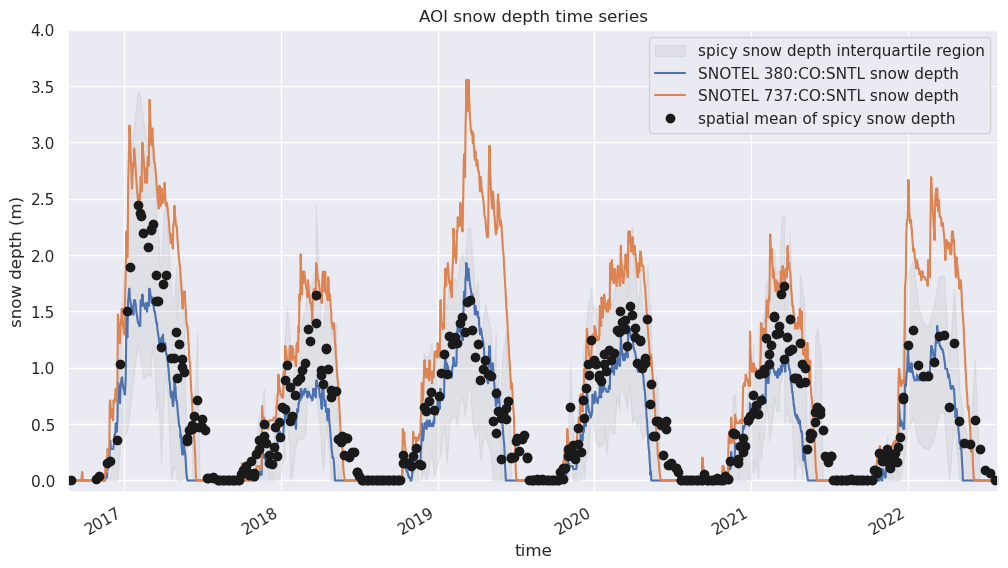

In [6]:
# plot snow depth time series
sns.set_theme()
f, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(ds.snow_depth.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').time,
                ds.snow_depth.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').values,
                ds.snow_depth.quantile(q=0.75, dim=['x', 'y']).dropna('time').values,
                alpha=0.1, color='Grey', label='spicy snow depth interquartile region')
for site in sntl_ds.Location:
    sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
ds.snow_depth.mean(dim=['x', 'y']).plot(marker='o', linestyle='', c='k', label='spatial mean of spicy snow depth')
ax.set_xlim(ds.time[0], ds.time[-1])
ax.set_ylim(-0.1, 4)
ax.set_ylabel('snow depth (m)')
ax.legend()
ax.set_title('AOI snow depth time series')

plt.savefig('./figs/multi_sd_ts.png', dpi=300)

In [7]:
# select SNOTEL measurements during Sentinel-1 overpass
sntl_ds_overpass = sntl_ds.sel(Date=ds.time, method='nearest')

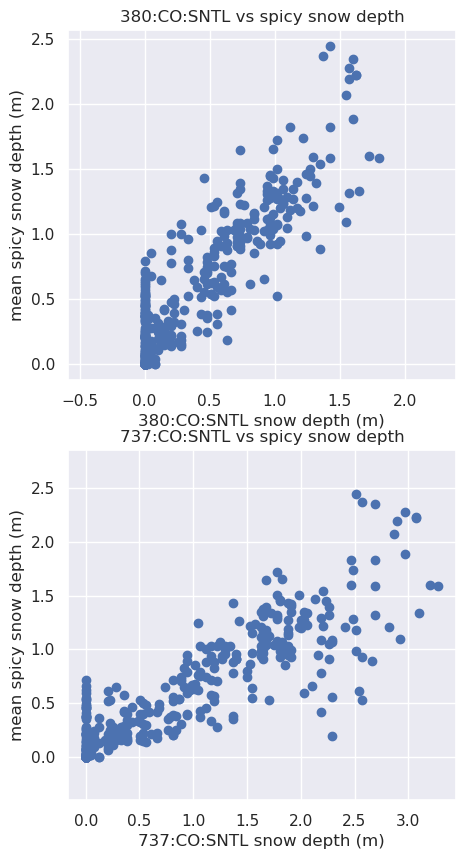

In [8]:
# plot spicy vs snotel snow depths
f, ax = plt.subplots(len(sntl_ds.Location), 1, figsize=(5, len(sntl_ds.Location)*5))
for i, site in enumerate(sntl_ds.Location):
    ax[i].scatter(sntl_ds_overpass.sel(Location=site).SNWD, ds.snow_depth.mean(dim=['x', 'y']))
    ax[i].set_aspect('equal', 'datalim')
    ax[i].set_title(f'{site.values} vs spicy snow depth')
    ax[i].set_xlabel(f'{site.values} snow depth (m)')
    ax[i].set_ylabel('mean spicy snow depth (m)')
    
plt.savefig('./figs/multi_snotelvspicy.png', dpi=300)

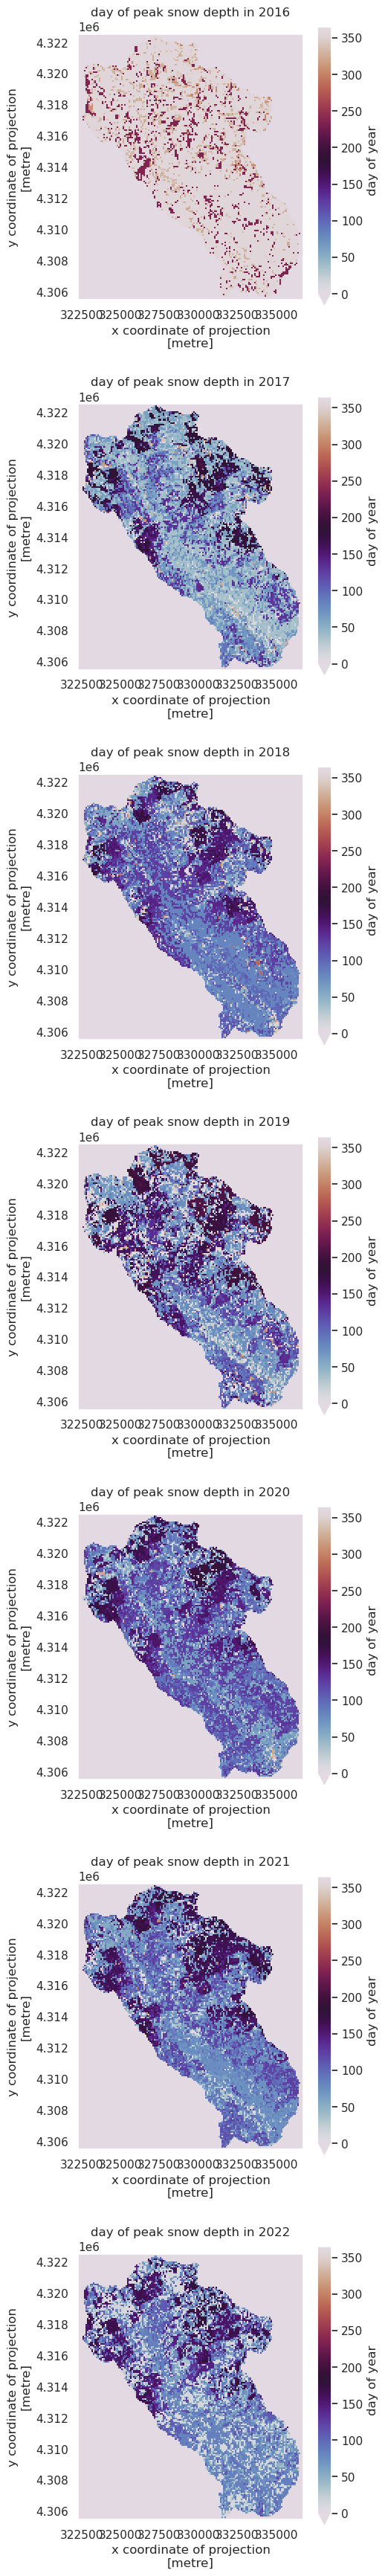

In [9]:
f, ax = plt.subplots(len(set(ds.time.dt.year.values)), 1, figsize=(5, len(set(ds.time.dt.year.values))*5))
for i, year in enumerate(set(ds.time.dt.year.values)):
    ds.groupby('time.year')[year].snow_depth.idxmax(dim='time', skipna=True).dt.dayofyear.plot(ax=ax[i], 
                                                                cmap='twilight', 
                                                                vmin=0, vmax=365, 
                                                                cbar_kwargs={'label':'day of year'})
    ax[i].set_title(f'day of peak snow depth in {year}')
    ax[i].set_aspect('equal') 
    
plt.tight_layout()

plt.savefig('./figs/multi_peak_snow_day.png', dpi=300)

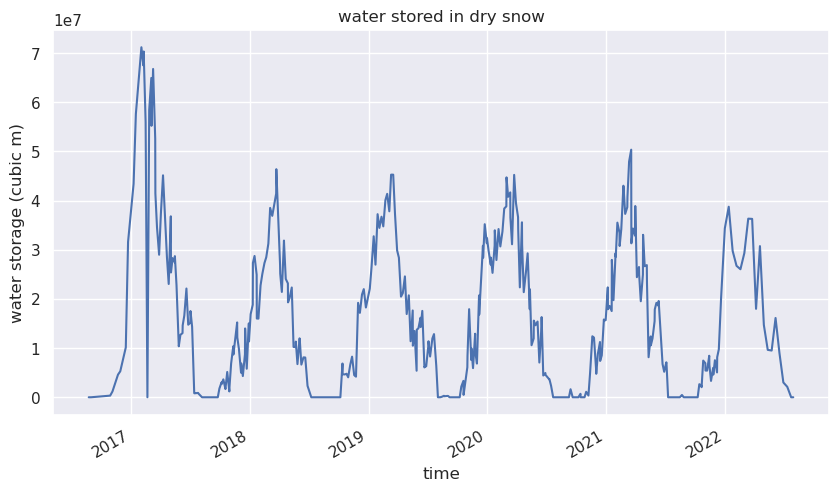

In [10]:
# assume a snow density of 0.3 g/cm^3
w_content = 0.3

# plot water storage over time
f, ax = plt.subplots(figsize=(10, 5))
(ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).plot(ax=ax)
ax.set_ylabel('water storage (cubic m)')
ax.set_title('water stored in snow')

plt.savefig('./figs/multi_water_storage.png', dpi=300)

In [11]:
for i, year in enumerate(set(ds.time.dt.year.values)):
    print(f'year: {year}',
          '\ndate of max storage: ',
          (ds.groupby('time.year')[year].snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).idxmax('time').dt.date.item(), 
          '\nmax storage (m^3): ',
          round((ds.groupby('time.year')[year].snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).max().item(), -2),
          '\nmax storage flight direction: ',
          (ds.groupby('time.year')[year].snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).idxmax().flight_dir.item(),
          '\nmax storage relative orbit: ',
          (ds.groupby('time.year')[year].snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).idxmax().relative_orbit.item())

year: 2016 
date of max storage:  2016-12-22 
max storage (m^3):  31598100.0 
max storage flight direction:  ascending 
max storage relative orbit:  151.0
year: 2017 
date of max storage:  2017-02-01 
max storage (m^3):  71163000.0 
max storage flight direction:  ascending 
max storage relative orbit:  49.0
year: 2018 
date of max storage:  2018-03-23 
max storage (m^3):  46373200.0 
max storage flight direction:  ascending 
max storage relative orbit:  151.0
year: 2019 
date of max storage:  2019-03-11 
max storage (m^3):  45259700.0 
max storage flight direction:  ascending 
max storage relative orbit:  49.0
year: 2020 
date of max storage:  2020-03-23 
max storage (m^3):  45213500.0 
max storage flight direction:  descending 
max storage relative orbit:  56.0
year: 2021 
date of max storage:  2021-03-18 
max storage (m^3):  50336400.0 
max storage flight direction:  descending 
max storage relative orbit:  56.0
year: 2022 
date of max storage:  2022-01-12 
max storage (m^3):  387366

In [12]:
# install USGS stream data retrieval package
!{sys.executable} -m pip install dataretrieval

In [13]:
import dataretrieval.nwis as nwis

In [14]:
# examine info for chosen gauge
gauge_id = '09112200' # NEED TO SET THIS MANUALLY
gauge_df, gauge_md = nwis.get_dv(sites=gauge_id,
                           start=ds.time[0].dt.strftime('%Y-%m-%d').item(),
                           end=ds.time[-1].dt.strftime('%Y-%m-%d').item())

In [15]:
# calculate total discharge per day in m^3
gauge_df['total_flow'] = gauge_df['00060_Mean']*86400*0.0283168

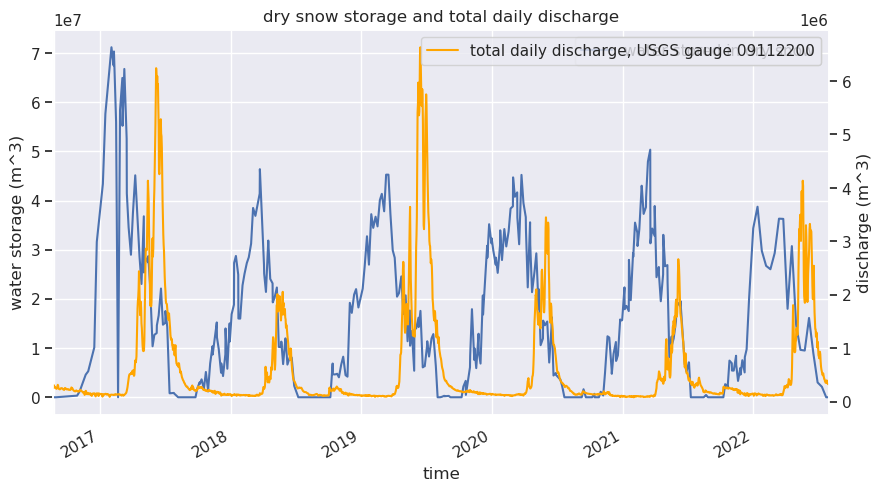

In [16]:
# plot water storage and streamflow over time
f, ax = plt.subplots(figsize=(10, 5))
(ds.snow_depth*w_content*float(ds.resolution)**2).sum(dim=['x', 'y']).plot(ax=ax, label='water stored in dry snow')
ax.set_ylabel('water storage (m^3)')
ax.set_title('snow storage and total daily discharge')
ax.legend()

ax2 = ax.twinx() 
(gauge_df['total_flow']).plot(ax=ax2, c='orange', label=f'total daily discharge, USGS gauge {gauge_id}')
ax2.set_ylabel('discharge (m^3)')
ax2.legend()

plt.grid(False)

plt.savefig('./figs/multi_water_storage_streamflow.png', dpi=300)